In [2]:
import pandas as pd
import numpy as np
import openap
from openap import prop
from openap import top
from pandarallel import pandarallel

import warnings
warnings.filterwarnings('ignore')

import fastmeteo
import matplotlib.pyplot as plt

import airportsdata
import osmnx as ox

## Get our challenge and submission datasets and combine into one df

In [3]:
challenge_set = pd.read_csv("/mnt/SMB_share/mark/flight_competition/challenge_set.csv")
challenge_set["dataset"] = "challenge"
submission_set = pd.read_csv("/mnt/SMB_share/mark/flight_competition/final_submission_set.csv")
submission_set["dataset"] = "submission"
datasets = pd.concat([challenge_set, submission_set])
datasets_trim = datasets[["adep", "ades", "aircraft_type"]].drop_duplicates()
datasets_trim

,adep,ades,aircraft_type
0,EGLL,EICK,A320
1,LEBL,KMIA,B772
2,ESSA,KORD,A333
3,LSZH,KPHL,B788
4,EIDW,EGLL,A21N
...,...,...,...
157619,EKCH,EPGD,E195
157674,EHAM,LSZH,A343
157685,LTCD,LTFM,B738
157722,EGLL,ENGM,A319


## Get fuel estimates from openap

In [6]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
def estimate_fuels(x): 

    try:
        actype = x["aircraft_type"]
        origin = x["adep"]
        destination = x["ades"]
    
        aircraft = prop.aircraft(actype)
        min_w = aircraft["oew"]
        max_w = aircraft["mtow"]
        mtow85 = max_w*.85
    
        mass_current = mtow85
    
    
        fuelflow = openap.FuelFlow(actype)
        
        optimizer = top.CompleteFlight(actype, origin, destination)
        flight = optimizer.trajectory(objective="fuel")
        
        flight["d_ts"] = flight["ts"] - flight["ts"].shift()
        flight["d_ts"] = flight["d_ts"].fillna(0)
    
        fuelflow_every_step = []
        fuel_every_step = []
        
        for i, row in flight.iterrows():
            ff = fuelflow.enroute(
                mass=mass_current,
                tas=row.tas,
                alt=row.altitude,
                vs=row.vertical_rate,
            )
            fuel = ff * row.d_ts
            fuelflow_every_step.append(ff)
            fuel_every_step.append(ff * row.d_ts)
            mass_current -= fuel
        
        flight = flight.assign(fuel_flow=fuelflow_every_step, fuel=fuel_every_step)
        #print(df)
    
        total_fuel = np.maximum(flight.fuel, 0).sum().astype(int)
        total_fuel_2 = flight.fuel.sum().astype(int)
        
        return [total_fuel, total_fuel_2, min_w, max_w, mtow85]

    except: 
        return [np.nan, np.nan, np.nan, np.nan, np.nan]


def get_mtows(x): 
    try:
        actype = x["aircraft_type"]
        origin = x["adep"]
        destination = x["ades"]
    
        aircraft = prop.aircraft(actype)
        min_w = aircraft["oew"]
        max_w = aircraft["mtow"]
        mtow85 = max_w*.85
        return [min_w, max_w]
    except Exception as e: 
        print(e)
        return [np.nan, np.nan]
        

In [8]:
datasets_trim[["total_fuel", "total_fuel_2", "min_w","max_w", "mtow85"]] = datasets_trim.parallel_apply(lambda x: estimate_fuels(x), axis=1, result_type="expand")

CasADi - 2024-10-18 01:09:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 878, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-10-18 01:09:53 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 878, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-10-18 01:09:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 896, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-10-18 01:09:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 878, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-10-18 01:09:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 878, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-10-18 01:09:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 878, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2024-10-18 01:09:55 WARNING("solver:nlp_g failed: NaN detected for output g, at (row 

In [9]:
datasets_trim.to_csv("test_openap.csv", index=False)

In [11]:
datasets_trim[["oew", "mtow"]] = datasets_trim.parallel_apply(lambda x: get_mtows(x), axis=1, result_type="expand")
datasets_trim

,adep,ades,aircraft_type,total_fuel,total_fuel_2,min_w,max_w,mtow85,oew,mtow
0,EGLL,EICK,A320,2057.0,2057.0,42600.0,78000.0,66300.0,42600.0,78000.0
1,LEBL,KMIA,B772,NaN,NaN,NaN,NaN,NaN,138000.0,297000.0
2,ESSA,KORD,A333,NaN,NaN,NaN,NaN,NaN,122780.0,242000.0
3,LSZH,KPHL,B788,NaN,NaN,NaN,NaN,NaN,119000.0,228000.0
4,EIDW,EGLL,A21N,NaN,NaN,NaN,NaN,NaN,50000.0,97000.0
...,...,...,...,...,...,...,...,...,...,...
157619,EKCH,EPGD,E195,NaN,NaN,NaN,NaN,NaN,28583.0,50790.0
157674,EHAM,LSZH,A343,NaN,NaN,NaN,NaN,NaN,130000.0,276000.0
157685,LTCD,LTFM,B738,3372.0,3372.0,41400.0,79000.0,67150.0,41400.0,79000.0
157722,EGLL,ENGM,A319,3537.0,3537.0,40800.0,75500.0,64175.0,40800.0,75500.0


## Calculate great circle distances for each adep/ades combination

In [12]:
manual_airports = {
'LTCU':{'icao': 'LTCU',
 'lat': 38.85858736260065,
 'lon': 40.59067139686379 
}, 
'LEIB':{'icao': 'LEIB',
 'lat': 38.87392171890811,
 'lon': 1.3722346680281414 
}, 
'DTNH':{'icao': 'DTNH',
 'lat': 36.0834437013865,
 'lon': 10.438704017504692 
}, 
'ESKS':{'icao': 'ESKS',
 'lat': 61.156101445931895,
 'lon': 12.837457063067493 
}, 
'EBCI':{'icao': 'EBCI',
 'lat': 50.463130022524915,
 'lon': 4.462079975151949 
}, 
'EBMB':{'icao': 'EBMB',
 'lat': 50.9154369162626,
 'lon': 4.493584452729591 
}, 
'LTCV':{'icao': 'LTCV',
 'lat': 37.36158697994315,
 'lon': 42.05553763068404
}, 
'OKBK':{'icao': 'OKBK',
 'lat': 37.36160005163285,
 'lon': 42.055506593027715 
}, 
'EGHH':{'icao': 'EGHH',
 'lat': 50.78100421147004,
 'lon': -1.8409717739922666 
}, 
'EGLL':{'icao': 'EGLL',
 'lat': 51.46794534067239,
 'lon': -0.45500243490457304 
}, 
'EKCH':{'icao': 'EKCH',
 'lat': 55.60955846679605,
 'lon': 12.63561794162437 
}, 
'LTFJ':{'icao': 'LTFJ',
 'lat': 40.90849582099669,
 'lon': 29.315195387558404 
}, 
'UTFF':{'icao': 'UTFF',
 'lat': 40.37598329652268,
 'lon': 71.75202477850446 
}, 
'EDDV':{'icao': 'EDDV',
 'lat': 52.462666312589754,
 'lon': 9.684258394471607
}, 
'EBBR':{'icao': 'EBBR',
 'lat': 50.90019751841645,
 'lon': 4.486028487284325
}, 
'EGCN':{'icao': 'EGCN',
 'lat': 53.39443776608614,
 'lon': -1.3842738109711732
}, 
'EGCC':{'icao': 'EGCC',
 'lat': 53.35534409298594,
 'lon':  -2.2771244490697478
}, 
'EGBB':{'icao': 'EGBB',
 'lat': 52.45236082325583,
 'lon': -1.7435028355783422
}, 
'EGKK':{'icao': 'EGKK',
 'lat': 51.15364864102023,
 'lon': -0.18207899325080945
}, 
'EKYT':{'icao': 'EKYT',
 'lat': 57.095703276939744,
 'lon': 9.855358741769924
}, 
'LTAC':{'icao': 'LTAC',
 'lat': 40.11496213059108,
 'lon': 32.99271320586336
}, 
'EHAM':{'icao': 'EHAM',
 'lat': 52.31690578306712,
 'lon': 4.74592996442235
}, 
'EGSY':{'icao': 'EGSY',
 'lat': 53.39926177010993,
 'lon': -1.3841440642047664
}, 
'LTFM':{'icao': 'LTFM',
 'lat': 41.275238322317286,
 'lon': 28.732290831634593
}}

In [13]:
airports = airportsdata.load()
airports.update(manual_airports)
#airports

In [14]:
fail_list = []

def get_great_circle(row, airports): 

    try: 
        start_icao = row["adep"]
        end_icao = row["ades"]
        start_info = airports[start_icao]
        end_info = airports[end_icao]
    
        dist = ox.distance.great_circle(
        start_info["lat"], start_info["lon"], end_info["lat"], end_info["lon"],
        earth_radius=6371009) * 0.000621371
    except Exception as e:
        print(e)
        #print([start_icao, end_icao])
        fail_list.append(start_icao)
        fail_list.append(end_icao)
        return np.nan

    return dist

In [16]:
datasets_trim["great_circle_miles"] = datasets_trim.parallel_apply(lambda x: get_great_circle(x, airports), axis=1)
print(list(set(fail_list)))

[]


In [17]:
datasets_trim

,adep,ades,aircraft_type,total_fuel,total_fuel_2,min_w,max_w,mtow85,oew,mtow,great_circle_miles
0,EGLL,EICK,A320,2057.0,2057.0,42600.0,78000.0,66300.0,42600.0,78000.0,345.260072
1,LEBL,KMIA,B772,NaN,NaN,NaN,NaN,NaN,138000.0,297000.0,4688.045888
2,ESSA,KORD,A333,NaN,NaN,NaN,NaN,NaN,122780.0,242000.0,4260.121521
3,LSZH,KPHL,B788,NaN,NaN,NaN,NaN,NaN,119000.0,228000.0,4013.989694
4,EIDW,EGLL,A21N,NaN,NaN,NaN,NaN,NaN,50000.0,97000.0,279.504141
...,...,...,...,...,...,...,...,...,...,...,...
157619,EKCH,EPGD,E195,NaN,NaN,NaN,NaN,NaN,28583.0,50790.0,246.189743
157674,EHAM,LSZH,A343,NaN,NaN,NaN,NaN,NaN,130000.0,276000.0,375.447722
157685,LTCD,LTFM,B738,3372.0,3372.0,41400.0,79000.0,67150.0,41400.0,79000.0,577.017278
157722,EGLL,ENGM,A319,3537.0,3537.0,40800.0,75500.0,64175.0,40800.0,75500.0,749.120922


## Add FAA data and clean up

In [18]:
faa = pd.read_csv("data/aircraft_data_faa.csv")
faa = faa[["ICAO_Code", "est_traffic_load_est",	"est_dry_operating_weight_est",	"MTOW_kg","MALW_kg"]]
faa = faa.rename(columns={"ICAO_Code":"aircraft_type"})
faa.head()

,aircraft_type,est_traffic_load_est,est_dry_operating_weight_est,MTOW_kg,MALW_kg
0,A20N,11289,42207,79000,67400
1,A21N,11343,48535,95000,79200
2,A310,15351,79438,144000,123999
3,A319,8627,41504,76500,61000
4,A320,11289,42207,78000,66000


In [19]:
datasets_trim = datasets_trim.merge(faa, on="aircraft_type", how="left")
datasets_trim

,adep,ades,aircraft_type,total_fuel,total_fuel_2,min_w,max_w,mtow85,oew,mtow,great_circle_miles,est_traffic_load_est,est_dry_operating_weight_est,MTOW_kg,MALW_kg
0,EGLL,EICK,A320,2057.0,2057.0,42600.0,78000.0,66300.0,42600.0,78000.0,345.260072,11289,42207,78000,66000
1,LEBL,KMIA,B772,NaN,NaN,NaN,NaN,NaN,138000.0,297000.0,4688.045888,20786,139255,297556,213188
2,ESSA,KORD,A333,NaN,NaN,NaN,NaN,NaN,122780.0,242000.0,4260.121521,25225,122744,242000,187000
3,LSZH,KPHL,B788,NaN,NaN,NaN,NaN,NaN,119000.0,228000.0,4013.989694,29499,119977,227930,172365
4,EIDW,EGLL,A21N,NaN,NaN,NaN,NaN,NaN,50000.0,97000.0,279.504141,11343,48535,95000,79200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10250,EKCH,EPGD,E195,NaN,NaN,NaN,NaN,NaN,28583.0,50790.0,246.189743,9000,27753,52290,45800
10251,EHAM,LSZH,A343,NaN,NaN,NaN,NaN,NaN,130000.0,276000.0,375.447722,21906,130183,276500,192000
10252,LTCD,LTFM,B738,3372.0,3372.0,41400.0,79000.0,67150.0,41400.0,79000.0,577.017278,13018,41078,79016,66349
10253,EGLL,ENGM,A319,3537.0,3537.0,40800.0,75500.0,64175.0,40800.0,75500.0,749.120922,8627,41504,76500,61000


In [20]:
datasets_trim["mtow_fill"] = datasets_trim["mtow"].fillna(datasets_trim["MTOW_kg"])
datasets_trim["oew_fill"] = datasets_trim["oew"].fillna(datasets_trim["est_dry_operating_weight_est"])

In [21]:
datasets_trim = datasets_trim[["aircraft_type","adep", "ades", "great_circle_miles", "mtow_fill", "oew_fill", "total_fuel"]].drop_duplicates()
datasets_trim

,aircraft_type,adep,ades,great_circle_miles,mtow_fill,oew_fill,total_fuel
0,A320,EGLL,EICK,345.260072,78000.0,42600.0,2057.0
1,B772,LEBL,KMIA,4688.045888,297000.0,138000.0,NaN
2,A333,ESSA,KORD,4260.121521,242000.0,122780.0,NaN
3,B788,LSZH,KPHL,4013.989694,228000.0,119000.0,NaN
4,A21N,EIDW,EGLL,279.504141,97000.0,50000.0,NaN
...,...,...,...,...,...,...,...
10250,E195,EKCH,EPGD,246.189743,50790.0,28583.0,NaN
10251,A343,EHAM,LSZH,375.447722,276000.0,130000.0,NaN
10252,B738,LTCD,LTFM,577.017278,79000.0,41400.0,3372.0
10253,A319,EGLL,ENGM,749.120922,75500.0,40800.0,3537.0


<Axes: xlabel='great_circle_miles', ylabel='total_fuel'>

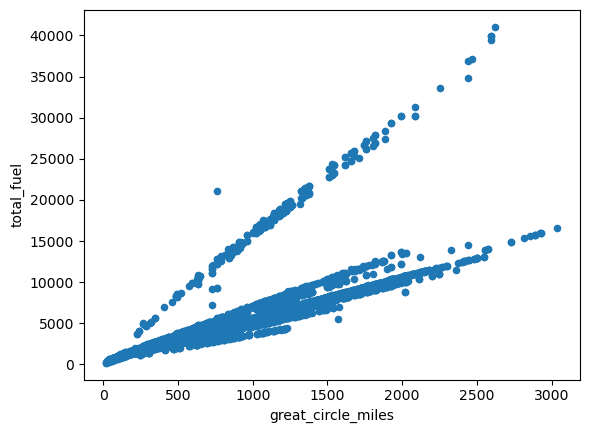

In [22]:
datasets_trim.plot.scatter(x="great_circle_miles", y="total_fuel")

## Fill in missing values with linear estimates

In [23]:
have_missing = datasets_trim[datasets_trim["total_fuel"].isna()]["aircraft_type"].unique()
have_missing

array(['B772', 'A333', 'B788', 'A21N', 'A20N', 'B789', 'CRJ9', 'B77W',
       'BCS3', 'AT76', 'B763', 'BCS1', 'E195', 'B38M', 'A359', 'E190',
       'B39M', 'A343', 'B738', 'B737', 'A319', 'A321', 'A320', 'A332',
       'B739', 'A310', 'B752', 'B773', 'C56X', 'E290'], dtype=object)

In [24]:
all_types = pd.DataFrame([])

for aircraft_type in datasets_trim["aircraft_type"].unique(): 
    this_type = datasets_trim[(datasets_trim["aircraft_type"]==aircraft_type)]
    this_type_no_null = this_type[this_type["total_fuel"].notnull() & this_type["great_circle_miles"].notnull()]
    print(len(this_type))
    if len(this_type_no_null) > 1:
        coef = np.polyfit(this_type_no_null["great_circle_miles"],this_type_no_null["total_fuel"],1)
        poly1d_fn = np.poly1d(coef) 
        this_type["total_fuel_regression"] = this_type.apply(lambda x: poly1d_fn(x["great_circle_miles"]), axis=1)
    
    all_types = pd.concat([all_types, this_type])

all_types


1158
92
277
338
400
733
2364
268
586
295
347
132
325
77
130
112
200
250
1308
199
301
97
113
101
39
2
4
3
1
3


,aircraft_type,adep,ades,great_circle_miles,mtow_fill,oew_fill,total_fuel,total_fuel_regression
0,A320,EGLL,EICK,345.260072,78000.0,42600.0,2057.0,2079.383478
6,A320,EGAC,EGLL,312.911291,78000.0,42600.0,1902.0,1925.078746
10,A320,LOWW,EDDM,220.766883,78000.0,42600.0,1465.0,1485.546939
11,A320,LSZH,ESGG,721.553524,78000.0,42600.0,3869.0,3874.315416
16,A320,EGKK,EIDW,301.104084,78000.0,42600.0,1852.0,1868.757988
...,...,...,...,...,...,...,...,...
9955,B773,LLBG,KMIA,6591.512979,299300.0,160500.0,NaN,NaN
8141,C56X,LSZH,LFMN,270.772104,9163.0,12800.0,NaN,NaN
9175,E290,EGLL,LSZH,489.332144,56400.0,28080.0,NaN,NaN
9987,E290,LSZH,EGLC,472.057164,56400.0,28080.0,NaN,NaN


In [25]:
still_missing = all_types[all_types["total_fuel_regression"].isna()]["aircraft_type"].unique()
still_missing

array(['B772', 'B788', 'A21N', 'A20N', 'B789', 'CRJ9', 'B77W', 'BCS3',
       'AT76', 'B763', 'BCS1', 'E195', 'B38M', 'A359', 'B39M', 'A343',
       'A310', 'B752', 'B773', 'C56X', 'E290'], dtype=object)

In [26]:
replacers = {}

for missing in still_missing: 
    mtow = all_types[all_types["aircraft_type"]==missing].iloc[0]["mtow_fill"]
    without = all_types[(all_types["aircraft_type"] != missing) & all_types["total_fuel_regression"].notnull()]
    found = without.iloc[(without['mtow_fill']-mtow).abs().argsort()[0]]
    # print(missing)
    # print(mtow)
    # print(found["aircraft_type"])
    # print(found["mtow_fill"])
    replacers[missing] = found["aircraft_type"]
    
replacers

{'B772': 'A333',
 'B788': 'A332',
 'A21N': 'A321',
 'A20N': 'B738',
 'B789': 'A333',
 'CRJ9': 'E190',
 'B77W': 'A333',
 'BCS3': 'B737',
 'AT76': 'E190',
 'B763': 'A321',
 'BCS1': 'B737',
 'E195': 'E190',
 'B38M': 'B738',
 'A359': 'A333',
 'B39M': 'B739',
 'A343': 'A333',
 'A310': 'A321',
 'B752': 'A321',
 'B773': 'A333',
 'C56X': 'E190',
 'E290': 'E190'}

In [27]:
def add_replacers(row, replacers): 
    try:
        result = replacers[row["aircraft_type"]]
        return result
    except: 
        return row["aircraft_type"]

In [28]:
datasets_trim["replacer"] = datasets_trim.apply(lambda x: add_replacers(x, replacers), axis=1)
datasets_trim

,aircraft_type,adep,ades,great_circle_miles,mtow_fill,oew_fill,total_fuel,replacer
0,A320,EGLL,EICK,345.260072,78000.0,42600.0,2057.0,A320
1,B772,LEBL,KMIA,4688.045888,297000.0,138000.0,NaN,A333
2,A333,ESSA,KORD,4260.121521,242000.0,122780.0,NaN,A333
3,B788,LSZH,KPHL,4013.989694,228000.0,119000.0,NaN,A332
4,A21N,EIDW,EGLL,279.504141,97000.0,50000.0,NaN,A321
...,...,...,...,...,...,...,...,...
10250,E195,EKCH,EPGD,246.189743,50790.0,28583.0,NaN,E190
10251,A343,EHAM,LSZH,375.447722,276000.0,130000.0,NaN,A333
10252,B738,LTCD,LTFM,577.017278,79000.0,41400.0,3372.0,B738
10253,A319,EGLL,ENGM,749.120922,75500.0,40800.0,3537.0,A319


In [29]:
all_types = pd.DataFrame([])

for aircraft_type in datasets_trim["replacer"].unique(): 
    this_type = datasets_trim[(datasets_trim["replacer"]==aircraft_type)]
    this_type_no_null = this_type[this_type["total_fuel"].notnull() & this_type["great_circle_miles"].notnull()]
    this_type_no_null_orig = this_type_no_null[this_type_no_null["aircraft_type"] == aircraft_type]
    print(len(this_type))
    if len(this_type_no_null) > 1:
        coef = np.polyfit(this_type_no_null_orig["great_circle_miles"],this_type_no_null_orig["total_fuel"],1)
        poly1d_fn = np.poly1d(coef) 
        this_type["total_fuel_regression"] = this_type.apply(lambda x: poly1d_fn(x["great_circle_miles"]), axis=1)
    
    all_types = pd.concat([all_types, this_type])

all_types

1158
908
451
1104
4405
756
347
826
300


,aircraft_type,adep,ades,great_circle_miles,mtow_fill,oew_fill,total_fuel,replacer,total_fuel_regression
0,A320,EGLL,EICK,345.260072,78000.0,42600.0,2057.0,A320,2079.383478
6,A320,EGAC,EGLL,312.911291,78000.0,42600.0,1902.0,A320,1925.078746
10,A320,LOWW,EDDM,220.766883,78000.0,42600.0,1465.0,A320,1485.546939
11,A320,LSZH,ESGG,721.553524,78000.0,42600.0,3869.0,A320,3874.315416
16,A320,EGKK,EIDW,301.104084,78000.0,42600.0,1852.0,A320,1868.757988
...,...,...,...,...,...,...,...,...,...
10148,B39M,EPWA,LTFM,836.412350,88000.0,45000.0,NaN,B739,5449.534289
10167,B739,LTCB,LTFM,486.776403,85100.0,44600.0,NaN,B739,3363.867478
10168,B39M,LTFM,ESGG,1344.072287,88000.0,45000.0,NaN,B739,8477.854150
10187,B739,LTFM,DAOO,1627.195753,85100.0,44600.0,10097.0,B739,10166.757194


In [30]:
all_types["total_fuel_fill"] = all_types["total_fuel"].fillna(all_types["total_fuel_regression"])
all_types

,aircraft_type,adep,ades,great_circle_miles,mtow_fill,oew_fill,total_fuel,replacer,total_fuel_regression,total_fuel_fill
0,A320,EGLL,EICK,345.260072,78000.0,42600.0,2057.0,A320,2079.383478,2057.000000
6,A320,EGAC,EGLL,312.911291,78000.0,42600.0,1902.0,A320,1925.078746,1902.000000
10,A320,LOWW,EDDM,220.766883,78000.0,42600.0,1465.0,A320,1485.546939,1465.000000
11,A320,LSZH,ESGG,721.553524,78000.0,42600.0,3869.0,A320,3874.315416,3869.000000
16,A320,EGKK,EIDW,301.104084,78000.0,42600.0,1852.0,A320,1868.757988,1852.000000
...,...,...,...,...,...,...,...,...,...,...
10148,B39M,EPWA,LTFM,836.412350,88000.0,45000.0,NaN,B739,5449.534289,5449.534289
10167,B739,LTCB,LTFM,486.776403,85100.0,44600.0,NaN,B739,3363.867478,3363.867478
10168,B39M,LTFM,ESGG,1344.072287,88000.0,45000.0,NaN,B739,8477.854150,8477.854150
10187,B739,LTFM,DAOO,1627.195753,85100.0,44600.0,10097.0,B739,10166.757194,10097.000000


In [31]:
all_types.drop_duplicates().to_csv("data/types_with_regression.csv", index=False)

In [32]:
merge_data = datasets.merge(all_types, on=["aircraft_type", "adep", "ades"], how="left")
merge_data.head()

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,...,flown_distance,tow,dataset,great_circle_miles,mtow_fill,oew_fill,total_fuel,replacer,total_fuel_regression,total_fuel_fill
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,...,321,54748.000000,challenge,345.260072,78000.0,42600.0,2057.0,A320,2079.383478,2057.000000
1,248760618,2022-01-01,f6f610e73002b8892a239a81321f7f1d,LEBL,Barcelona,ES,KMIA,Miami,US,2022-01-01T09:55:00Z,...,4193,185441.000000,challenge,4688.045888,297000.0,138000.0,NaN,A333,70057.306105,70057.306105
2,248753824,2022-01-01,139670936660762c230ca92556ba842b,ESSA,Stockholm Arlanda,SE,KORD,Chicago O'Hare,US,2022-01-01T09:39:00Z,...,3770,230396.000000,challenge,4260.121521,242000.0,122780.0,NaN,A333,63802.357345,63802.357345
3,248753852,2022-01-01,509dc61bb54fbab0e5406067c95603e2,LSZH,Zurich,CH,KPHL,Philadelphia,US,2022-01-01T11:04:00Z,...,3607,157615.000000,challenge,4013.989694,228000.0,119000.0,NaN,A332,58742.869255,58742.869255
4,248755934,2022-01-01,d0610d000dcf26b1d7bba8103ecc393d,EIDW,Dublin,IE,EGLL,London Heathrow,GB,2022-01-01T12:36:00Z,...,305,70318.447226,challenge,279.504141,97000.0,50000.0,NaN,A321,2306.200351,2306.200351


In [33]:
merge_data.to_csv("data/datasets_with_regression.csv", index=False)